# Week4授業課題 信用情報を学習しよう   

この授業の目的   
- データに近いものの学習推定を行う

## 信用情報

Week3でEDAを行ったKaggleの Home Credit Default Risk コンペティションの学習および推定を行います。データはWeek3でEDAを行ったものを使用してください。

### ・EDA, 前処理
(主にWeek3で行ったものを前提に進める)

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import lightgbm as lgb

#DataFrameで表示できる行列の最大数を設定
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 100)

/Users/yuhisoejima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#データの読み込み
df = pd.read_csv('application_train.csv')
df_test = pd.read_csv('application_test.csv')
sk_id = df_test['SK_ID_CURR']

In [3]:
#info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB


In [4]:
#欠損値の数を数え、降順にソート
total = df.isnull().sum().sort_values(ascending=False)

#欠損値の割合を計算し、降順にソート
missing_ratio = ((df.isnull().sum() / df.isnull().count()) * 100).sort_values(ascending=False)

#DataFrameを作成
df_na = pd.concat([total, missing_ratio], axis=1, keys=['Total', 'missing_ratio'])
df_na.head(70)

,Total,missing_ratio
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


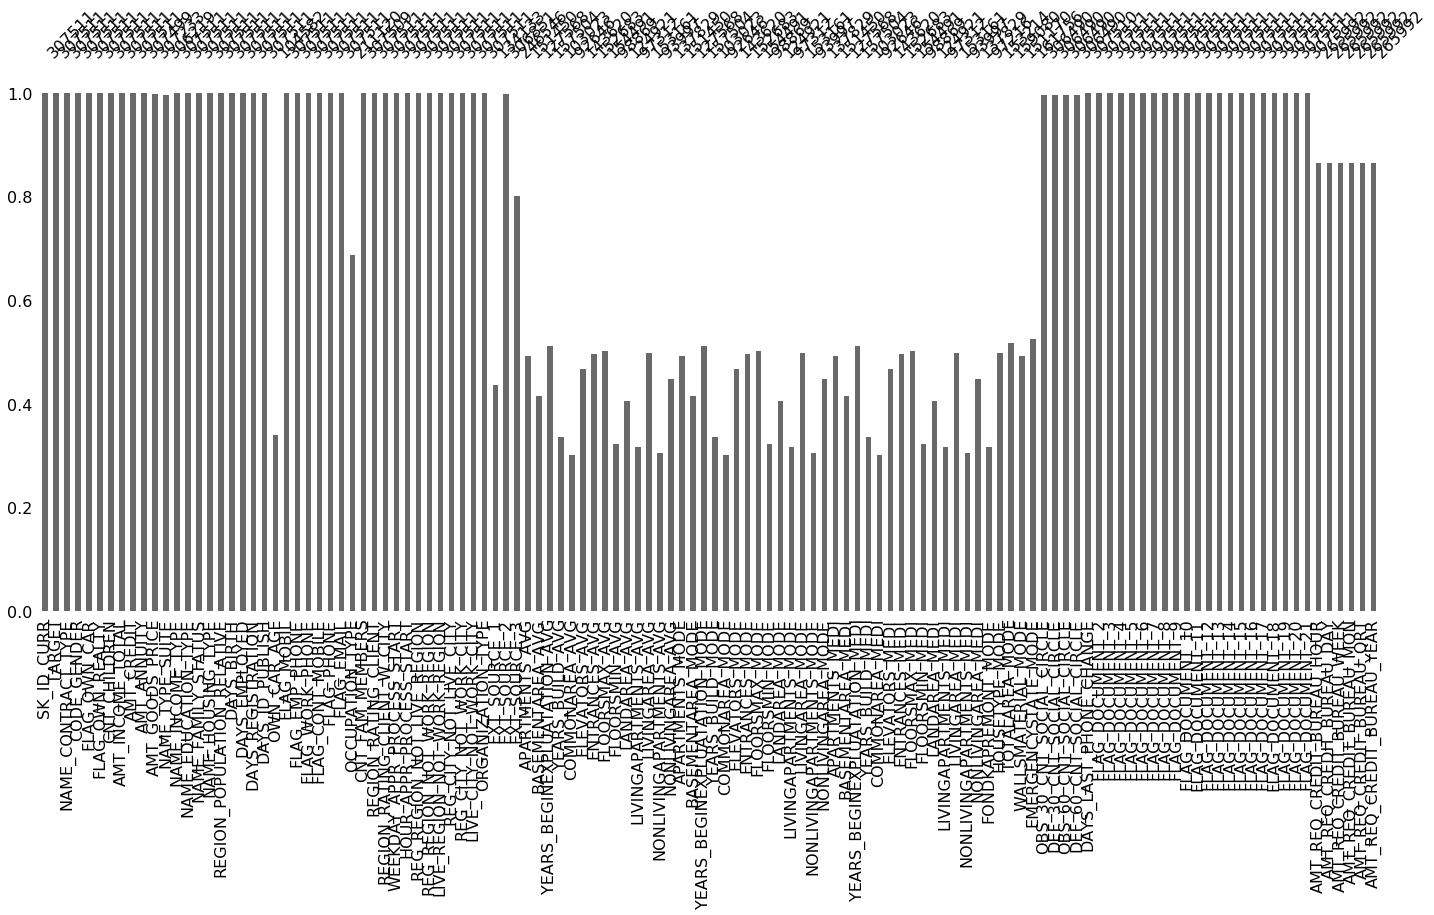

In [5]:
#非欠損値の数の棒グラフを表示
msno.bar(df);

In [6]:
#object型のみ抽出
df_object_list = df.select_dtypes(include=object).columns

#one-hot encoding
df_onehot = pd.get_dummies(df[df_object_list])

#結合
df = pd.concat([df, df_onehot], axis=1)

#one_hot encodingする前の特徴量を削除
df.drop(columns=df_object_list, inplace=True)
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business

In [7]:
#とりあえず欠損値を含む特徴量を全削除
df = df.dropna(axis=1)

#説明変数と目的変数をndarrayに格納
X = df.iloc[:, 2:].values
y = df['TARGET'].values

#データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y)

## 【問題1】 パイプラインの作成

授業前課題で行ったことを参考に、学習し推定結果を出すまでの一連の流れを行ってください。テストデータに対して推定を行い、それをKaggleに提出してみましょう。この段階では高い精度を出す必要はありません。

In [8]:
def pipeline(X_train, X_test, y_train, cls):
    '''
    モデルの学習から推測するまでの関数
    Parameters
    ----------------
    X_train : {array-like, sparse matrix}, shape (n_samples, n_features)
        学習用データ
    X_test : array_like or sparse matrix, shape (n_samples, n_features)
        検証用データ
    y_train : array-like, shape (n_samples,)
        学習用ラベル
    cls : class
        学習モデル
    
    Returns
    -----------
    y_pred_proba : array-like, shape = [n_samples,]
        TARGETが1のときの確率
    '''
    #パイプラインの作成
    pipe_cls = make_pipeline(StandardScaler(), 
                                            PCA(),
                                            cls)
    
    #学習
    pipe_cls.fit(X_train, y_train)
    
    #推測
    y_pred_proba = pipe_cls.predict_proba(X_test)[:, 1]

    return y_pred_proba

In [9]:
def auc_score(y_test, y_pred):
    '''
    AUCスコアとROC曲線を出力する関数
    Parameters
    ----------------
    y_test :  array_like or sparse matrix, shape (n_samples,)
        検証用ラベル
    y_pred : array-like, shape = [n_samples,]
        あるターゲットの確率
    '''
    #aucを計算
    auc = roc_auc_score(y_test, y_pred)

    #FPR、TPRを取得
    fpr, tpr, th = roc_curve(y_test, y_pred)

    #ROC曲線を作成
    plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
    plt.legend()
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True)
    
    #AUCを出力
    print('AUC :', auc)

/Users/yuhisoejima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


AUC : 0.6682680852602942


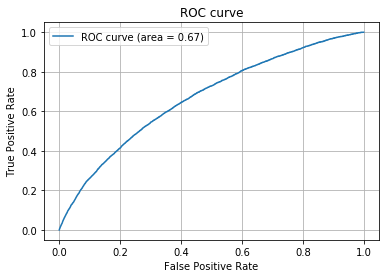

In [10]:
#LogisticRegressionで予測
lr_pred = pipeline(X_train, X_test, y_train, LogisticRegression(solver='lbfgs'))

#ROC曲線とAUCを出力
auc_score(y_test, lr_pred)

In [11]:
#テストデータに同様の処理をする
#one-hot encoding
df_test_onehot = pd.get_dummies(df_test[df_object_list])

#結合
df_test = pd.concat([df_test, df_test_onehot], axis=1)

#one_hot encodingする前の特徴量を削除
df_test.drop(columns=df_object_list, inplace=True)

#欠損値を含む特徴量を全削除
df_test = df_test.dropna(axis=1)

#ndarrayに変換
test_features = df_test.iloc[:, 1:].values

#予測
test_pred = pipeline(X_train, test_features, y_train, LogisticRegression(solver='lbfgs'))

/Users/yuhisoejima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/yuhisoejima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/sklearn/linear_model/base.py:297: RuntimeWarning: overflow encountered in exp
  np.exp(prob, prob)


In [12]:
#testデータをcsvに保存
homecredit_submission = pd.DataFrame({ 'SK_ID_CURR': sk_id,'TARGET': test_pred})
homecredit_submission.to_csv("homecredit_submission.csv", index=False)

スコアは0.50000であり、trainデータと乖離があった。

## 【問題2】 指標値の関数作成

このコンペティションでは提出した確率から指標値 AUC が計算され、それで順位が決まります。（Evaluationのページ参照）

![](image/image1.png)

このAUCを計算する関数を作成してください。

In [13]:
def auc(y_test, y_pred):
    
    #FPRとTPRを取得
    fpr, tpr, th = roc_curve(y_test, y_pred)
    
    #空のリスト
    auc_list = []
    
    #ROC曲線を台形の集合として計算
    for i in range(len(fpr)):
        if i != 0:
            #リストに格納
            auc_list.append((tpr[i] + tpr[i-1]) * abs(fpr[i] - fpr[i-1]) / 2)
        
    #台形を合計する
    return sum(auc_list)

In [14]:
auc(y_test, lr_pred)

0.6682680852602949

作成したAUCの関数は約0.668であり、auc_scoreで求めたものも約0.668であったので、同様の関数が作成できていた。

## 【問題3】 前処理・Feature Engineering・学習

精度を上げるために前処理・Feature Engineeringを行ってください。そしてその特徴量によって学習、検証、再び前処理の流れを繰り返しましょう。この工程はEDAの続きとも言えます。Week3で学んだことを思い出しながら進めてください。

汎化性能が高いモデルが作成できたと判断した場合は再びKaggleに提出をしましょう。

In [15]:
#再度データの読み込み
df = pd.read_csv('application_train.csv')
df_test = pd.read_csv('application_test.csv')
sk_id = df_test['SK_ID_CURR']
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [16]:
#object型のみ抽出
df_object_list = df.select_dtypes(include=object).columns

#one-hot encoding
df_onehot = pd.get_dummies(df[df_object_list])

#結合
df = pd.concat([df, df_onehot], axis=1)

#one_hot encodingする前の特徴量を削除
df.drop(columns=df_object_list, inplace=True)
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business

In [17]:
#重要度の算出
lgb = lgb.LGBMClassifier()

#特徴量の名前
feat_labels = df.columns[2:]

#説明変数と目的変数をndarrayに格納
X_features = df.iloc[:, 2:].values
y_features = df['TARGET'].values

#モデルを適合
lgb.fit(X_features, y_features)

#重要度の算出
importances = lgb.feature_importances_

##重要度の降順で特徴量インデックスを抽出
indices = np.argsort(importances)[::-1]

#出力
print('Feature Importances:')
for i in (range(40)):
    print('\t{0:20s} : {1:>.6f}'.format(feat_labels[indices[i]], importances[indices[i]]))

Feature Importances:
	EXT_SOURCE_1         : 265.000000
	EXT_SOURCE_3         : 226.000000
	EXT_SOURCE_2         : 200.000000
	DAYS_BIRTH           : 191.000000
	AMT_CREDIT           : 157.000000
	AMT_ANNUITY          : 143.000000
	AMT_GOODS_PRICE      : 140.000000
	DAYS_EMPLOYED        : 96.000000
	DAYS_ID_PUBLISH      : 95.000000
	OWN_CAR_AGE          : 85.000000
	DAYS_LAST_PHONE_CHANGE : 79.000000
	DAYS_REGISTRATION    : 73.000000
	AMT_INCOME_TOTAL     : 53.000000
	REGION_POPULATION_RELATIVE : 46.000000
	AMT_REQ_CREDIT_BUREAU_YEAR : 39.000000
	CODE_GENDER_F        : 34.000000
	NAME_EDUCATION_TYPE_Higher education : 30.000000
	NAME_CONTRACT_TYPE_Cash loans : 29.000000
	NAME_FAMILY_STATUS_Married : 29.000000
	AMT_REQ_CREDIT_BUREAU_QRT : 27.000000
	HOUR_APPR_PROCESS_START : 25.000000
	REGION_RATING_CLIENT_W_CITY : 24.000000
	DEF_30_CNT_SOCIAL_CIRCLE : 24.000000
	LANDAREA_MODE        : 24.000000
	YEARS_BEGINEXPLUATATION_MODE : 21.000000
	TOTALAREA_MODE       : 20.000000
	LANDAREA_AVG   

重要度の高いEXT_SOURCE_1、EXT_SOURCE_2、EXT_SOURCE_3、DAYS_BIRTHで学習を行う。

In [18]:
#データの絞り込み
df_list = ['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
df = df[df_list]
df.head()

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
0,1,0.083037,0.262949,0.139376,-9461
1,0,0.311267,0.622246,NaN,-16765
2,0,NaN,0.555912,0.729567,-19046
3,0,NaN,0.650442,NaN,-19005
4,0,NaN,0.322738,NaN,-19932


In [19]:
#欠損値を平均で埋める
df['EXT_SOURCE_1'].fillna(df['EXT_SOURCE_1'].mean(), inplace=True)
df['EXT_SOURCE_2'].fillna(df['EXT_SOURCE_2'].mean(), inplace=True)
df['EXT_SOURCE_3'].fillna(df['EXT_SOURCE_3'].mean(), inplace=True)
df.head()

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
0,1,0.083037,0.262949,0.139376,-9461
1,0,0.311267,0.622246,0.510853,-16765
2,0,0.502130,0.555912,0.729567,-19046
3,0,0.502130,0.650442,0.510853,-19005
4,0,0.502130,0.322738,0.510853,-19932


In [20]:
#データをndrrayに格納
X = df.iloc[:, 1:].values
y = df['TARGET'].values

#データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y)

AUC : 0.7152921571853831


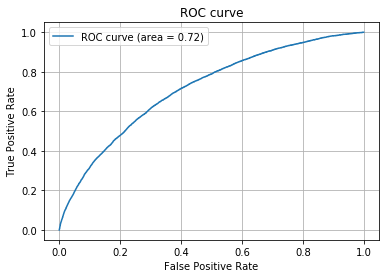

In [21]:
#ロジスティック回帰で予測
lr_pred= pipeline(X_train, X_test, y_train, LogisticRegression(solver='lbfgs'))
auc_score(y_test, lr_pred)

In [22]:
def gridserch(X_train, X_test, y_train, y_test, param_grid, cls):
    '''
    グリッドサーチを行う関数
    Parameters
    ----------------
    X_train : {array-like, sparse matrix}, shape (n_samples, n_features)
        学習用データ
    X_test : array_like or sparse matrix, shape (n_samples, n_features)
        検証用データ
    y_train : array-like, shape (n_samples,)
        学習用ラベル
    y_test : array-like, shape (n_samples,)
        検証用ラベル
    param_grid : dict or list of dictionaries
        検証パラメータ
    cls : class
        学習モデル
    '''
    #パイプラインの作成
    pipe_cls = make_pipeline(StandardScaler(), cls)

    #グリッドサーチ
    cls_gs = GridSearchCV(estimator=pipe_cls,
                                      param_grid=param_grid,
                                      scoring='roc_auc', 
                                      cv=5)

    #fit
    cls_gs.fit(X_train, y_train)

    #結果の出力
    print('Test set score: {}'.format(cls_gs.score(X_test, y_test)))
    print('Best parameters: {}'.format(cls_gs.best_params_))
    print('Best cross-validation: {}'.format(cls_gs.best_score_))

In [23]:
#グリッドサーチ
#検証パラメータ
lr_param_grid = {'logisticregression__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}
gridserch(X_train, X_test, y_train, y_test, lr_param_grid, LogisticRegression(solver='lbfgs'))

Test set score: 0.7153303020516018
Best parameters: {'logisticregression__C': 0.001}
Best cross-validation: 0.7215338533648027


AUC : 0.7153303020516018


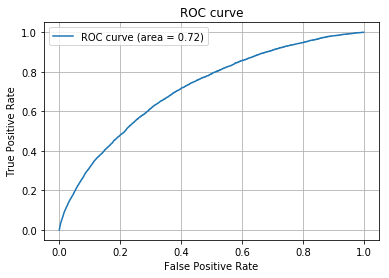

In [24]:
#グリットサーチ後のロジスティック回帰での予測
lr_gs_pred = pipeline(X_train, X_test, y_train, LogisticRegression(solver='lbfgs', C=0.001))
auc_score(y_test, lr_gs_pred)

In [25]:
#テストデータに同様の処理をする
#データの絞り込み
df_test_list = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
df_test = df_test[df_test_list]

#欠損値を平均で埋める
df_test['EXT_SOURCE_1'].fillna(df_test['EXT_SOURCE_1'].mean(), inplace=True)
df_test['EXT_SOURCE_2'].fillna(df_test['EXT_SOURCE_2'].mean(), inplace=True)
df_test['EXT_SOURCE_3'].fillna(df_test['EXT_SOURCE_3'].mean(), inplace=True)

#ndarrayに変換
test_features = df_test.values

#予測
test_pred = pipeline(X_train, test_features, y_train, LogisticRegression(solver='lbfgs', C=0.001))

In [26]:
homecredit_submission = pd.DataFrame({ 'SK_ID_CURR': sk_id,'TARGET': test_pred})
homecredit_submission.to_csv("homecredit_submission.csv", index=False)

スコアが0.71203にまで上がり、trainデータとの乖離もあまりなくなった。   
これ以降の検証はSprint1で行う。